<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/RNN_Ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM (Long Short Time Memory)

Estas Redes Neuronales resuelven el problema de la pérdida de memoria en series de tiempo muy largas, es decir, memoriza a largo plazo.

**¿Como funciona una Neurona LSTM?**

Recordemos el funcionamiento de una RNN.

Los datos pasados funcinaran como input para la salida del $x_{t+1}$ proyectado.

<img src="https://torres.ai/wp-content/uploads/2019/09/redes-neuronales-recurrentes-deep-learning-jordi-torres-1024x535.png">

En las Redes LSTM, tendremos:

**1.- FORGET GATE LAYER (Capa de puerta del olvido)**
Es la primera parte en donde se decide la información que se va a deshechar.

Aplicamos una transformación lineal a:

$x_{t}$ **(Input:Tiempo $t$ de la serie)** 
 
$h_{t-1}$ **(Output: salida de la capa oculta $h_{t-1}$ )**

**Tranformación lineal** 

$f_{t} = \sigma(W_{f} \cdot [h_{t-1},x_{t}]+b_{f})$

$\bullet$ $\sigma$ = Función de activación sigmoide

$\bullet$ $W_{f}$ = Pesos asignados a la función

$\bullet$ $b_{f}$ = Sesgo

**Nota:** Transformación con soporte de la función entre 0 y 1.

El 1 representa que se mantiene toda la información y el 0 es deshechar toda a infromación. En este paso se determina que se olvida y que no.

**2.- Input Gate Layer (Capa de puerta de entrada)**

$i_{t}$ = $\sigma(W_{f} \cdot [h_{t-1},x_{t}]+b_{f})$

**Nota:** En este paso se vuelve a aplicar una transformación sigmoide pero ahora a la tranformación lineal.$

**3.- Creación de nuevo candidato de valores a partir de $C_{t-1}$**

$\bar{C_{t}}$ = $\tanh(W_{c} \cdot [h_{t-1},x_{t}]+b_{c})$

**Nota:** En este paso se pasa la tranformación lineal por una tranformación $\tanh$ para crear/almacenar un vector que se llamara "nuevo candidato" que son los valores del estado de celda.

**4.-Actualización de estado de celda $C_{t}$**

$C_{t}$ = $f_{t} \cdot C_{t-1} + i_{t} \cdot \bar{C_{t}}$

**Nota:** El antiguo estado de celda se multiplica por la transformación lineal para que en caso de ser 0, se olvide la información y en caso de ser 1 se mantenga.

Después, lo agregamos a la transformación sigmoide aplicada a la tranformación lineal que a su vez estará multiplicada por el vector de "Nuevo candidato".

Por lo tanto el resultado serán los nuevos valores candidatos que estarán escalados por cuanto decidimos actualizar cada valor sumado por el olvido o el mantenimiento de los valores de $C_{t-1}$.


**5.-Obtención de  $h_{t}$**

$O_{t}$ = $\sigma(W_{o}[h_{t-1},x_{t}]+b_{o})$

$h_{t}$ = $o_{t} \cdot \tanh(C_{t})$

**Nota:** Tomamos nuevamente la información anterior $h_{t-1}$ y $x_{t}$, les hacemos una trasformación sigmoide y con esto decidimos que parte del estado de celda vamos a generar como output y luego colocamos el estado de celda que obtuvimos en el paso anterior $C_{t}$ y le aplicamos una transformación $\tanh$ para que los valores esten entre -1 y 1 para después multiplicarlo por $O_{t}$.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/datasets/AlcoholSales.csv',index_col='DATE',parse_dates=True)
#Frecuencua mensual
df.index.freq = 'MS'
df.columns = ['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


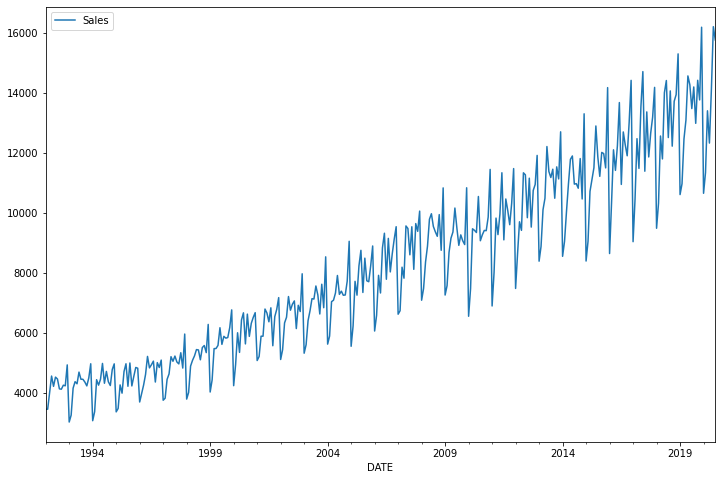

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


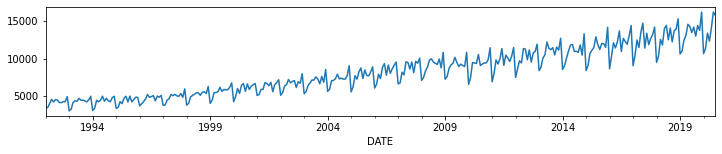

In [7]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

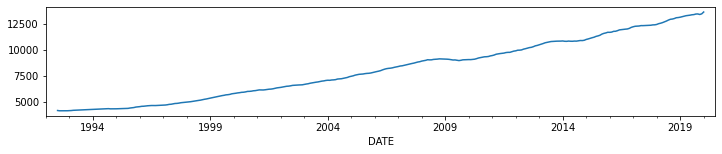

In [8]:
results.trend.plot(figsize=(12,2))

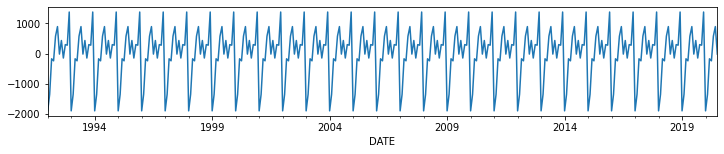

In [9]:
results.seasonal.plot(figsize=(12,2))

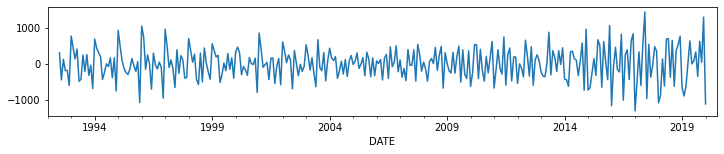

In [10]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [11]:
len(df)

343

In [12]:
len(df)-12 

331

### Recordemos que como e suna serie temporal no podemos partir el dato aleatoriamente, dado que si importa el orden cronologico.

In [13]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [14]:
len(test)

12

## Escalando los datos

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
# Utilizamos MinMaxScaler para estandarizar recordando que solo se utiliza para los datos de entrenamiento,
# porque si no, el modelo ya habra visto los datos con los que se validara
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
# Una vez que Scale ya aprendio a escalar mis datos ahora si lo aplicamos a los 2 sets
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
#Datos de entrenamiento escalados
#Datos entre 0 y 1
scaled_train

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922],
       [0.12201678],
       [0.11688523],
       [0.09008715],
       [0.08919117],
       [0.10002444],
       [0.09847683],
       [0.1551682 ],
       [0.        ],
       [0.01873422],
       [0.09196058],
       [0.1096359 ],
       [0.10393419],
       [0.13561945],
       [0.11623361],
       [0.11615215],
       [0.10857701],
       [0.09815101],
       [0.11965464],
       [0.15826342],
       [0.00358394],
       [0.02818278],
       [0.11501181],
       [0.10018734],
       [0.11639651],
       [0.1591594 ],
       [0.10531889],
       [0.13749287],
       [0.10939155],
       [0.09912845],
       [0.14278733],
       [0.15801906],
       [0.02761261],
       [0.03689827],
       [0.10083897],
       [0.07843936],
       [0.13716706],
       [0.15826342],
       [0.09709212],
       [0.1603812 ],
       [0.09806956],
       [0.12405311],
       [0.14824469],
       [0.146

In [21]:
# Definimos el generator
#Definimos el numero de entradas con n_input
n_input = 2
#Definimos el número de caracteristicas con n_features
n_features = 1
#En nuestro caso la data es el mismo que el target, es donde tenemos los datos y es con los que compararemos las predicciones
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
len(scaled_train)

331

In [23]:
len(generator) # n_input = 2

329

In [24]:
scaled_train[:5]

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922]])

In [25]:
# ¿Cómo luce el primer batch?
# Hasta este momento solo estamos creando los batch que utilizara la red neuronal
generator[0]

(array([[[0.03486194],
         [0.03478048]]]), array([[0.07909098]]))

In [26]:
X,y = generator[0]

In [27]:
#Como podemos observar se utilizan 2 periodos para hacer una predicción
#Todo esto por como se definio el batch
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.03486194 0.03478048]
Predicción: 
 [[0.07909098]]


In [28]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
#Esto tiene sentido si observamos que la serie tiene un ciclo "anual" o estacionalidad "anual"
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [29]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [30]:
#Lo que tenemos ahora son 12 periodos y con esto predicimos el periodo 13
#Esta será la configuración del batch (lote) y esto es con lo que se entrenara la RNN
#Debemos tener en cuenta que entre más grande sea el batch_size aumenta la complejidad del modelo, aumentando a su vez el riesgo de overfitting
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predict this y: 
 [[0.]]


### Creando el Modelo

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
# define model
#Primero creamos el modelo secuencial
model = Sequential()
#Añadimos capas
#El primer parámetro es la cantidad de neuronas, la segunda la función de activación y la tercera las entradas y el número de caracteristicas
#El número de neuronas se ajusta a prueba y error
#La función de activación es a consideracion nuestra
#Las dimensiones de entrada que este caso son las del batch, en este caso es (12,1)
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#Aquí agregamos la capa densa que lo que hara es juntar todas las neuronas en 1 sola predicción
model.add(Dense(1))
#Compilamos
#Aquí indicamos como función de coste el MSE y como optimizador el ADAM
model.compile(optimizer='adam', loss='mse')

In [33]:
#Dado que el modelo LSTM es complejo, los parámetros a ajustar son 40800 por lo que tarda su compilación 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit model
#En el caso de que tuvieramos datos utilizariamos .fit pero como es un objeto generador, utilizamos fit_generator
#Indicamos las epochs, que son las carreras que hará el modelo a tráves de los datos.
#Si notamos que el error no disminuye con n epochs hay que bajar el número de epochs
#Si notamos que sigue disminuyendo con n epochs, entonces hay que subirlas 
model.fit_generator(generator,epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0213
Epoch 2/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0085
Epoch 3/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 4/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 5/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0069
Epoch 6/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 7/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 8/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 9/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 10/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0027
Epoch 11/50
319/319 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 12/50
319/319 [==========

In [35]:
model.history.history.keys()

dict_keys(['loss'])

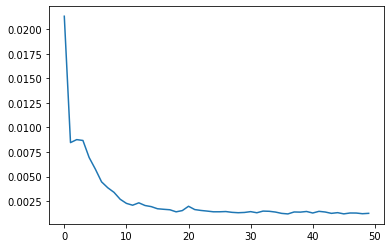

In [36]:
#Gráficamos el número de epochs en el eje de las x y en de la y, el valor de la función de pérdida
#En este caso quizás 20 o 25 epochs hubieran sido suficientes
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [37]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
#Como entrenamos el modelo con datos escalados, debemos introducir datos escalados.
first_eval_batch = scaled_train[-12:]

In [38]:
#Primer batch de evaluación
first_eval_batch

array([[0.89940539],
       [0.74936874],
       [0.87122261],
       [0.8893052 ],
       [1.        ],
       [0.61782194],
       [0.64714507],
       [0.76899894],
       [0.8199886 ],
       [0.94013195],
       [0.91602183],
       [0.8514295 ]])

In [39]:
#Dimensiones de "X" que es el generator (batch de 1x12)
#Y estas mismas dimensiones debe tener cualquier cosa que entre al modelo para predecir, ya que fue con lo que se entreno
X.shape

(1, 12, 1)

In [40]:
#Una vez creado el first_eval_batch para no tener problemas con las dimensiones, aplicamos un reshape
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [41]:
#Ya tenemos las dimensiones correctas
first_eval_batch.shape

(1, 12, 1)

In [42]:
#Ahora si hacemos el predict utilizando ese batch
#Y el output es el valor de la predicción
model.predict(first_eval_batch)

array([[0.9152247]], dtype=float32)

In [43]:
#Si lo comparamos con el primer valor del test, observamos que la predicción es cercana al valor real
scaled_test

array([[0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.75775841],
       [0.90250061],
       [1.07387798],
       [1.03763134]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

In [44]:
test_predictions = []

#Tomamos el número de datos escalados que necesitemos con n_input
first_eval_batch = scaled_train[-n_input:]
#Hacemos el reshape para resolver temas de dimensiones
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
test_predictions

[array([0.9152247], dtype=float32),
 array([0.77755606], dtype=float32),
 array([0.89773095], dtype=float32),
 array([0.92026174], dtype=float32),
 array([1.0223545], dtype=float32),
 array([0.6172726], dtype=float32),
 array([0.68935883], dtype=float32),
 array([0.78791094], dtype=float32),
 array([0.8591596], dtype=float32),
 array([0.9538605], dtype=float32),
 array([0.9274384], dtype=float32),
 array([0.87573266], dtype=float32)]

In [46]:
scaled_test

array([[0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.75775841],
       [0.90250061],
       [1.07387798],
       [1.03763134]])

In [51]:
#Podemos ver que el error de predicción con los datos escalados es pequeño
np.mean(scaled_test-test_predictions)**2/len(scaled_test)

4.199231870183389e-05

## Transformación inversa y Comparación

In [50]:
#Ahora necesitamos volver el escalamiento a los valores reales para poder comparar con los datos originales
true_predictions = scaler.inverse_transform(test_predictions)

In [52]:
true_predictions

array([[14267.21329033],
       [12577.05577004],
       [14052.44283068],
       [14329.05339038],
       [15582.44599521],
       [10609.25589967],
       [11494.25836146],
       [12704.18258905],
       [13578.90227187],
       [14741.5456202 ],
       [14417.16097081],
       [13782.36987042]])

In [53]:
test

,Sales
DATE,
2019-08-01,14205
2019-09-01,12992
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197
2020-01-01,10659
2020-02-01,11350
2020-03-01,13410
2020-04-01,12334


In [54]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
test

,Sales,Predictions
DATE,,
2019-08-01,14205,14267.213290
2019-09-01,12992,12577.055770
2019-10-01,14427,14052.442831
2019-11-01,13773,14329.053390
2019-12-01,16197,15582.445995
2020-01-01,10659,10609.255900
2020-02-01,11350,11494.258361
2020-03-01,13410,12704.182589
2020-04-01,12334,13578.902272


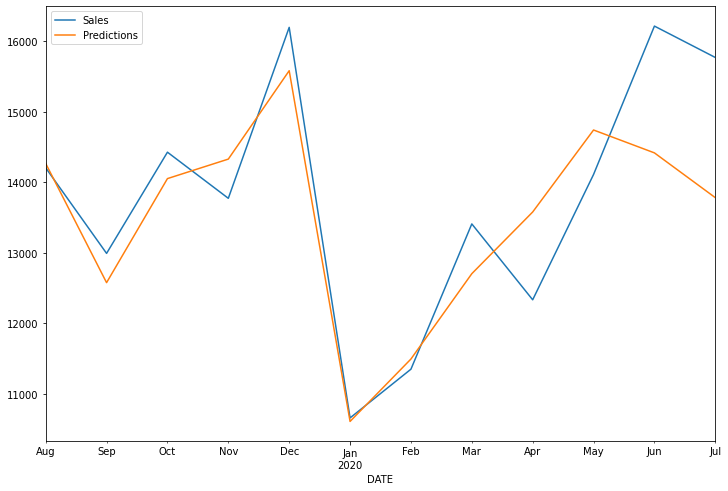

In [56]:
test.plot(figsize=(12,8))

In [66]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test.Sales,test.Predictions) 

887912.1332353223

# Guardar un Modelo

In [67]:
model.save('my_rnn_model.h5')

# Cargar un Modelo

In [ ]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
